# Mask vs Non-mask classifier
Author: Hudson M. S. Bruno\
hudson.bruno@ic.unicamp.br\
MO444/MC886\
Institute of Computing - Unicamp

We created a binary classifier for the dataset "COVID Face Mask Detection Dataset", available here: https://www.kaggle.com/datasets/prithwirajmitra/covid-face-mask-detection-dataset


In [1]:
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Load the data
### Raw data download


In [2]:
#Download from a google drive link
!gdown 1r9fNxD_5YU4p0SK7Z9D1D4WBzwa7QWZh

Downloading...
From: https://drive.google.com/uc?id=1r9fNxD_5YU4p0SK7Z9D1D4WBzwa7QWZh
To: /content/masks_dataset.zip
100% 217M/217M [00:01<00:00, 152MB/s]


In [3]:
!unzip -q masks_dataset.zip
!ls

masks_dataset  masks_dataset.zip  sample_data


In [4]:
!ls masks_dataset

test  train  validation


We can notice that the dataset already has the train, validation and test sets splitted.

In [5]:
train_dir = 'masks_dataset/train'
val_dir = 'masks_dataset/validation'
test_dir = 'masks_dataset/test'

Using Keras `image_dataset_from_directory` to create data loaders with binary labels.

In [6]:
random_seed = 42
img_size = (256, 256)
batch_size = 32
print('training data')
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                label_mode='binary',
                                                                seed=random_seed,
                                                                image_size=img_size,
                                                                batch_size=batch_size,)
print('validation data')
val_data = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                                label_mode='binary',
                                                                seed=random_seed,
                                                                image_size=img_size,
                                                                batch_size=batch_size,)
print('test data')
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='binary',
                                                                seed=random_seed,
                                                                image_size=img_size,
                                                                batch_size=batch_size,)

training data
Found 600 files belonging to 2 classes.
validation data
Found 306 files belonging to 2 classes.
test data
Found 100 files belonging to 2 classes.


Data visualization - Notice that label 0 means wearing mask and label 1 means not wearing mask


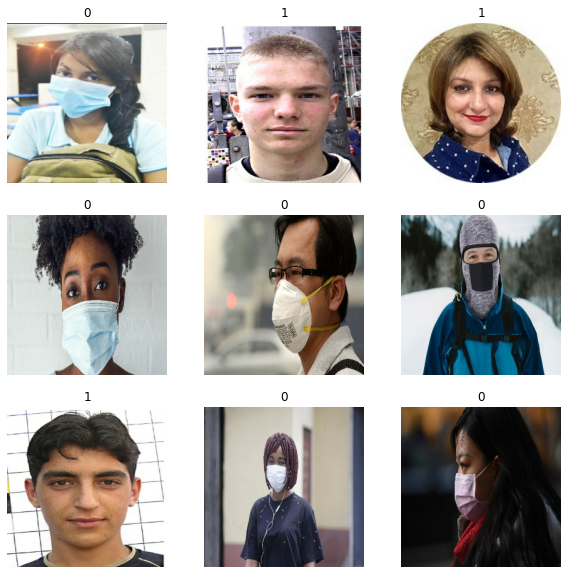

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Using image data augmentation

When you don't have a large image dataset, it's a good practice to artificially
introduce sample diversity by applying random yet realistic transformations to the
training images.


In [11]:
data_augmentation = keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),
                                      layers.RandomTranslation(0.1,0.1),
                                      layers.RandomRotation(0.1),
                                      layers.RandomZoom(0.1),])

Visualization of a random image with data augmentation

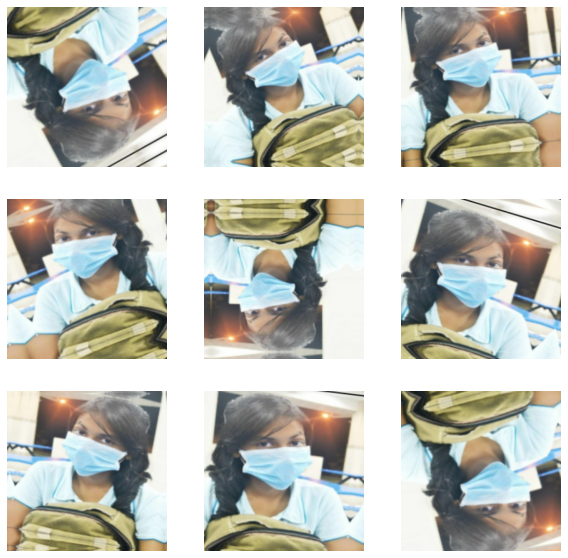

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_data.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


## Standardizing the data

Our images are already in a standard size (256x256), as they are being yielded as contiguous `float32` batches by our data loaders. However, their RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network;
in general you should seek to make your input values small. Here, we will
standardize values to be in the `[0, 1]` by using a `Rescaling` layer at the start of our model.


**Configure the dataset for performance**

Let's make sure to use buffered prefetching so we can yield data from disk without
 having I/O becoming blocking:


In [16]:
train_data = train_data.prefetch(buffer_size=32)
val_data = val_data.prefetch(buffer_size=32)

#First Model - From Scratch

## Build the first model


In [ ]:
#A model built and trained from scratch

def make_model_scratch(input_shape):
    inputs = keras.Input(shape=input_shape+(3,))
    # Image augmentation block
    x = data_augmentation(inputs)
    # Rescale images
    x = layers.Rescaling(1.0 / 255)(x)

    # Starting CNN
    x = layers.Conv2D(8, 3, strides=2, padding="same")(x) #8 filters 3x3 with stride=2 and padding
    x = layers.BatchNormalization()(x) #Batch normalization
    x = layers.Activation("relu")(x) #activation function

    x = layers.Conv2D(16, 3, strides=2, padding="valid")(x) #16 filters 3x3 with stride=2 without padding
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2)(x) #pooling 3x3 with stride=2

    x = layers.Conv2D(16, 3, padding="valid")(x) #16 filters 3x3 with stride=1 without padding
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 3, padding="valid")(x) #32 filters 3x3 with stride=1 without padding
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(32, 3, padding="valid")(x) #32 filters 3x3 with stride=1 without padding
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D(3, strides=2)(x) #pooling 3x3 with stride = 2

    x = layers.Conv2D(64, 3, padding="valid")(x) #64 filters 3x3 with stride=1 without padding
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    #flatten data to FC network
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x) #50% dropout
    x = layers.Dense(128, activation="relu")(x)  #128 neurons
    outputs = layers.Dense(1, activation="sigmoid")(x) #sigmoid activation function (between 0 and 1)
    return keras.Model(inputs, outputs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 8)       224       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 8)      32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 8)       0         
                                                             

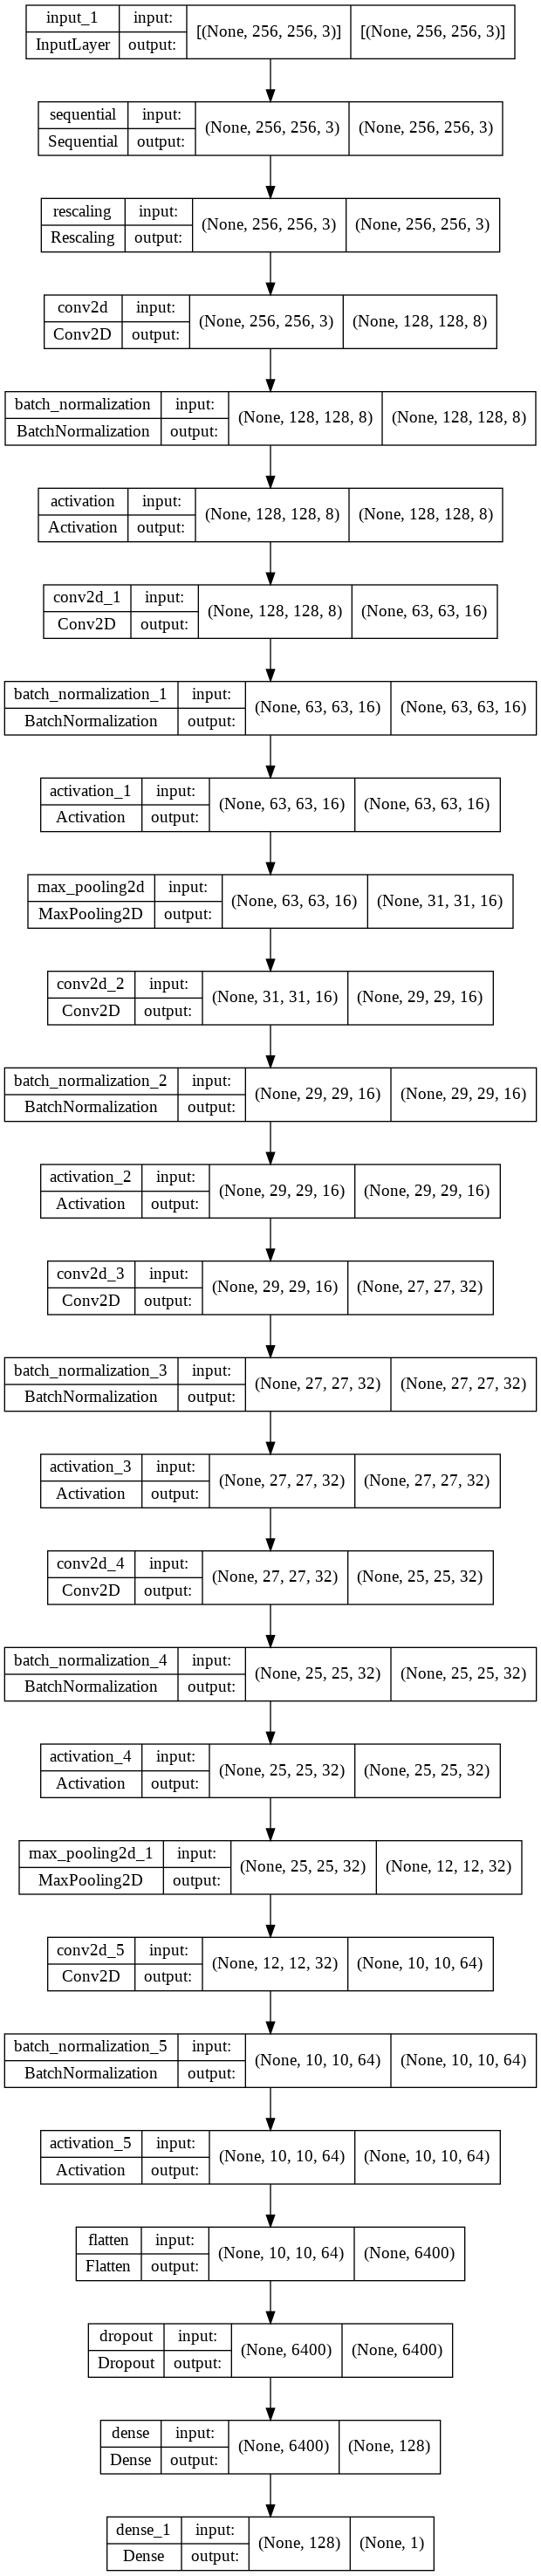

In [ ]:
#visualize the model
model1 = make_model_scratch(input_shape=img_size)
model1.summary()
keras.utils.plot_model(model1, show_shapes=True)

## Train the first model

In [ ]:
start = time.time()

epochs = 100
print('training first model')
#set early stopping
callbacks = [keras.callbacks.ModelCheckpoint('model1.h5', monitor='val_loss', save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                          min_delta=0.001,
                                          patience=10)]

model1.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"],)

history1 = model1.fit(train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data,)
end = time.time()
print('took ', end-start,' seconds to train ')

training first model
Epoch 1/100
19/19 [==============================] - 26s 1s/step - loss: 0.9420 - accuracy: 0.5083 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/100
19/19 [==============================] - 24s 1s/step - loss: 0.9352 - accuracy: 0.4833 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 3/100
19/19 [==============================] - 24s 1s/step - loss: 0.8924 - accuracy: 0.4867 - val_loss: 0.6915 - val_accuracy: 0.5098
Epoch 4/100
19/19 [==============================] - 24s 1s/step - loss: 0.8507 - accuracy: 0.5067 - val_loss: 0.6900 - val_accuracy: 0.5948
Epoch 5/100
19/19 [==============================] - 24s 1s/step - loss: 0.8064 - accuracy: 0.5383 - val_loss: 0.6890 - val_accuracy: 0.5131
Epoch 6/100
19/19 [==============================] - 23s 1s/step - loss: 0.8230 - accuracy: 0.5317 - val_loss: 0.6885 - val_accuracy: 0.5327
Epoch 7/100
19/19 [==============================] - 24s 1s/step - loss: 0.7803 - accuracy: 0.5250 - val_loss: 0.6880 - val_accuracy:

In [16]:
def plot_history(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()


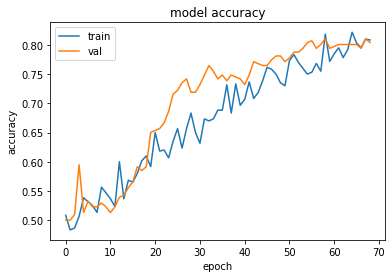

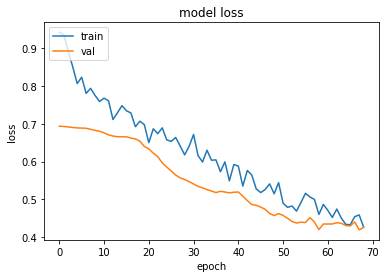

In [ ]:
plot_history(history1)

## Evaluation on test set
Note that data augmentation and dropout are inactive at inference time.


In [17]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    return model.predict(img_array)

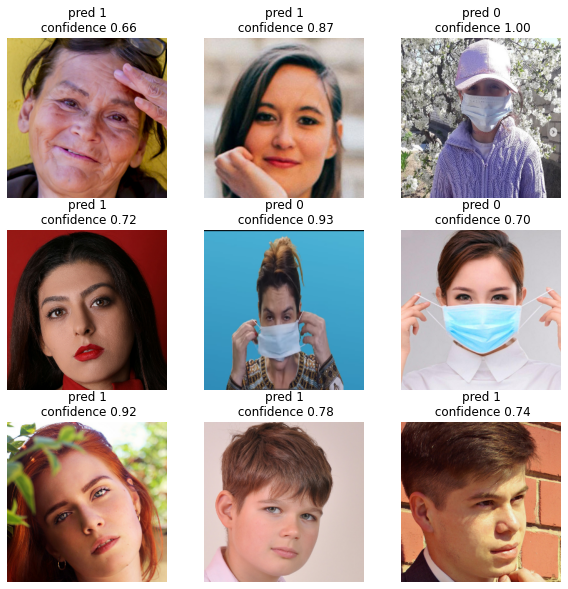

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred = predict(model1, images[i])[0][0]
        pred_class = round(pred)
        pred_conf = pred if pred_class == 1 else 1-pred
        plt.title(f'pred {round(pred)}\n confidence {pred_conf:.2f}')
        plt.axis("off")

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(y_true, y_pred):
  cfm = confusion_matrix(y_true, y_pred)
  sns.heatmap(cfm,annot=True,cmap="Blues")

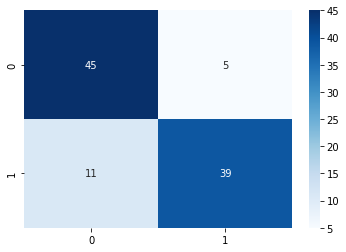

In [ ]:
import numpy as np

y_pred = []
y_true = []
for images, labels in test_data:
    label = np.array(labels)
    pred = model1.predict(images)
    for i in pred:
      y_pred.append(round(i[0]))
    for i in label: 
      y_true.append(int(i))

plot_confusion_matrix(y_true, y_pred)

# Second Model - Transfer learning

## Build the second model

In [12]:
#A model built and trained from scratch

def make_model_transfer_learning(input_shape):
    
    resnet = tf.keras.applications.ResNet50(include_top=False, #not using their FC layer
                                   weights="imagenet", input_shape=input_shape+(3,))
    resnet.trainable = False

    inputs = keras.Input(shape=input_shape+(3,))
    # Image augmentation block
    x = data_augmentation(inputs)
    # Rescale images
    x = layers.Rescaling(1.0 / 255)(x)
    x = resnet(x)
    
    #flatten data to FC network
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x) #50% dropout
    x = layers.Dense(1024, activation="relu")(x)  #1024 neurons
    x = layers.Dense(512, activation="relu")(x)  #512 neurons
    x = layers.Dense(128, activation="relu")(x)  #128 neurons
    outputs = layers.Dense(1, activation="sigmoid")(x) #sigmoid activation function (between 0 and 1)
    return keras.Model(inputs, outputs)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dropout (Dropout)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 1024)              134218

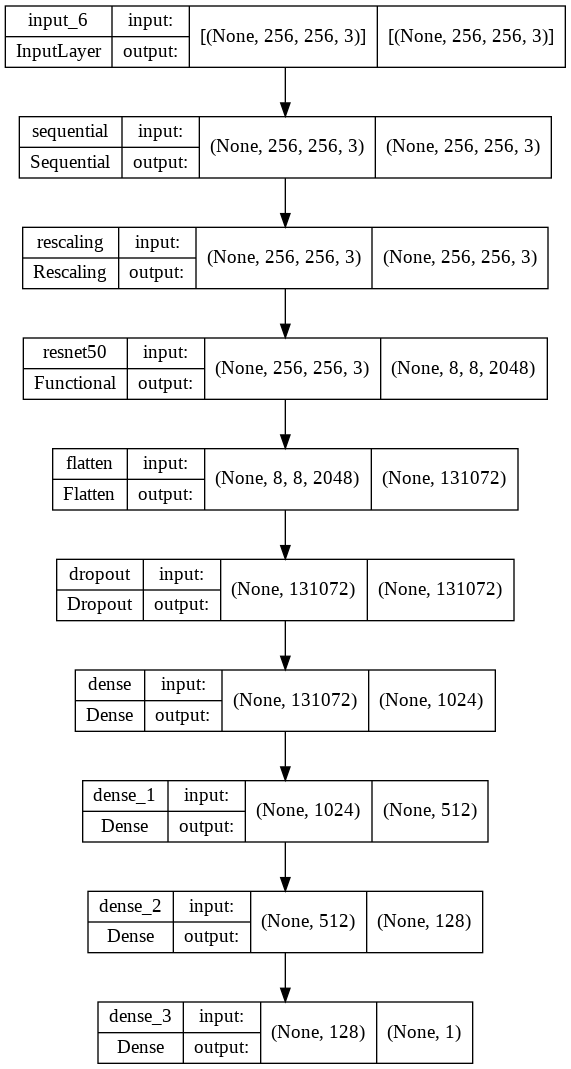

In [13]:
#visualize the model
model2 = make_model_transfer_learning(input_shape=img_size)
model2.summary()
keras.utils.plot_model(model2, show_shapes=True)

## Train the second model

In [14]:
start = time.time()

epochs = 100
print('training second model')
#set early stopping
callbacks = [keras.callbacks.ModelCheckpoint('model2.h5', monitor='val_loss', save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                          min_delta=0.001,
                                          patience=10)]

model2.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"],)

history2 = model2.fit(train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data,)
end = time.time()
print('took ', end-start,' seconds to train ')

training first model
Epoch 1/100
19/19 [==============================] - 192s 10s/step - loss: 0.7963 - accuracy: 0.4767 - val_loss: 0.7576 - val_accuracy: 0.5000
Epoch 2/100
19/19 [==============================] - 190s 10s/step - loss: 0.7401 - accuracy: 0.5067 - val_loss: 0.7166 - val_accuracy: 0.5000
Epoch 3/100
19/19 [==============================] - 187s 10s/step - loss: 0.7831 - accuracy: 0.4750 - val_loss: 0.7123 - val_accuracy: 0.5000
Epoch 4/100
19/19 [==============================] - 184s 10s/step - loss: 0.7564 - accuracy: 0.4950 - val_loss: 0.7499 - val_accuracy: 0.5000
Epoch 5/100
19/19 [==============================] - 192s 10s/step - loss: 0.7552 - accuracy: 0.4817 - val_loss: 0.6806 - val_accuracy: 0.5033
Epoch 6/100
19/19 [==============================] - 188s 10s/step - loss: 0.7290 - accuracy: 0.4983 - val_loss: 0.7181 - val_accuracy: 0.5000
Epoch 7/100
19/19 [==============================] - 188s 10s/step - loss: 0.7130 - accuracy: 0.5633 - val_loss: 0.7201 -

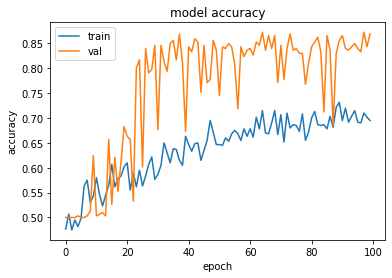

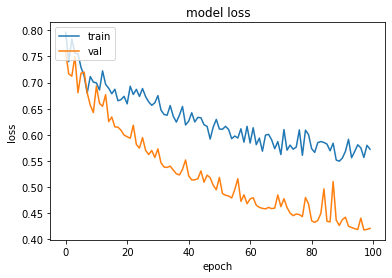

In [19]:
plot_history(history2)

## Evaluation on the test set

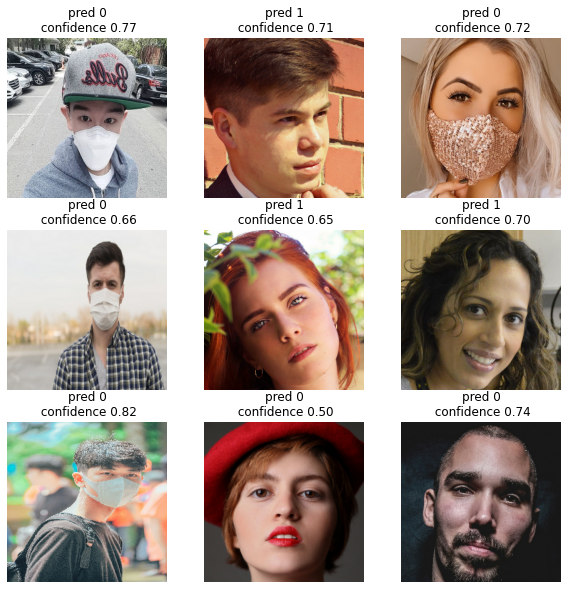

In [26]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred = predict(model2, images[i])[0][0]
        pred_class = round(pred)
        pred_conf = pred if pred_class == 1 else 1-pred
        plt.title(f'pred {round(pred)}\n confidence {pred_conf:.2f}')
        plt.axis("off")

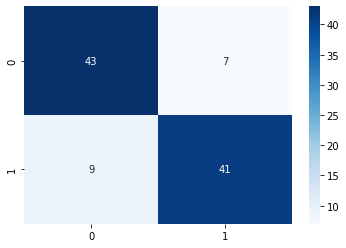

In [21]:
import numpy as np

y_pred = []
y_true = []
for images, labels in test_data:
    label = np.array(labels)
    pred = model2.predict(images)
    for i in pred:
      y_pred.append(round(i[0]))
    for i in label: 
      y_true.append(int(i))

plot_confusion_matrix(y_true, y_pred)

# Third model - Fine-tuning

## Build the third model

In [49]:
#A model built and trained from scratch

def make_model_fine_tuning(input_shape):
    resnet = tf.keras.applications.ResNet50(include_top=False, #not using their FC layer
                                   weights="imagenet", input_shape=input_shape+(3,))
    resnet.trainable = False
    n_layers = len(resnet.layers)
    for i in range(n_layers-10, n_layers):
      resnet.layers[i].trainable = True
    
    inputs = keras.Input(shape=input_shape+(3,))
    # Image augmentation block
    x = data_augmentation(inputs)
    # Rescale images
    x = layers.Rescaling(1.0 / 255)(x)
    x = resnet(x)
    
    #flatten data to FC network
    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x) #50% dropout
    x = layers.Dense(1024, activation="relu")(x)  #1024 neurons
    x = layers.Dense(512, activation="relu")(x)  #512 neurons
    x = layers.Dense(128, activation="relu")(x)  #128 neurons
    outputs = layers.Dense(1, activation="sigmoid")(x) #sigmoid activation function (between 0 and 1)
    return keras.Model(inputs, outputs)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling_6 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dropout_6 (Dropout)         (None, 131072)            0         
                                                                 
 dense_24 (Dense)            (None, 1024)              1342

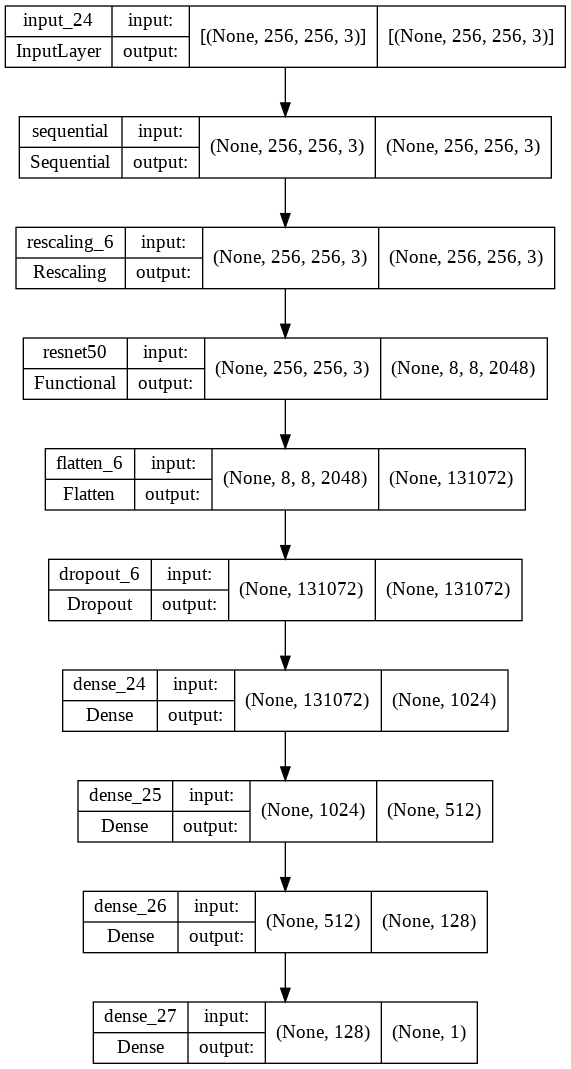

In [50]:
model3 = make_model_fine_tuning(input_shape=img_size)
model3.summary()
keras.utils.plot_model(model3, show_shapes=True)

## Train the third model

In [52]:
start = time.time()

epochs = 100
print('training third model')
#set early stopping
callbacks = [keras.callbacks.ModelCheckpoint('model3.h5', monitor='val_loss', save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_loss",
                                          min_delta=0.001,
                                          patience=10)]

model3.compile(optimizer=keras.optimizers.SGD(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"],)

history3 = model3.fit(train_data, epochs=epochs, callbacks=callbacks, validation_data=val_data,)
end = time.time()
print('took ', end-start,' seconds to train ')

training third model
Epoch 1/100
19/19 [==============================] - 199s 10s/step - loss: 0.7668 - accuracy: 0.5400 - val_loss: 0.7477 - val_accuracy: 0.5000
Epoch 2/100
19/19 [==============================] - 187s 10s/step - loss: 0.7565 - accuracy: 0.5233 - val_loss: 0.6994 - val_accuracy: 0.5065
Epoch 3/100
19/19 [==============================] - 187s 10s/step - loss: 0.7369 - accuracy: 0.5150 - val_loss: 0.6794 - val_accuracy: 0.5621
Epoch 4/100
19/19 [==============================] - 192s 10s/step - loss: 0.7424 - accuracy: 0.5283 - val_loss: 0.6689 - val_accuracy: 0.6634
Epoch 5/100
19/19 [==============================] - 190s 10s/step - loss: 0.7386 - accuracy: 0.5200 - val_loss: 0.6656 - val_accuracy: 0.6046
Epoch 6/100
19/19 [==============================] - 190s 10s/step - loss: 0.7367 - accuracy: 0.5150 - val_loss: 0.6605 - val_accuracy: 0.5948
Epoch 7/100
19/19 [==============================] - 190s 10s/step - loss: 0.7113 - accuracy: 0.5567 - val_loss: 0.6655 -

KeyboardInterrupt: ignored

In [ ]:
plot_history(history3)

## Evaluation on test set

In [56]:
model3 = keras.models.load_model('model3.h5')

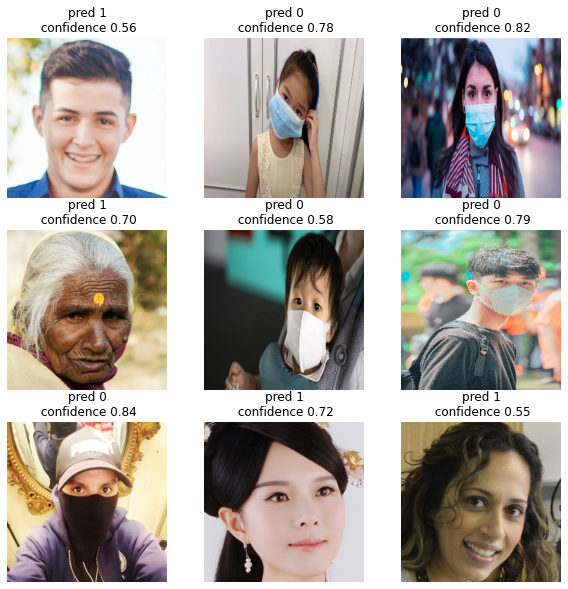

In [57]:
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred = predict(model3, images[i])[0][0]
        pred_class = round(pred)
        pred_conf = pred if pred_class == 1 else 1-pred
        plt.title(f'pred {round(pred)}\n confidence {pred_conf:.2f}')
        plt.axis("off")

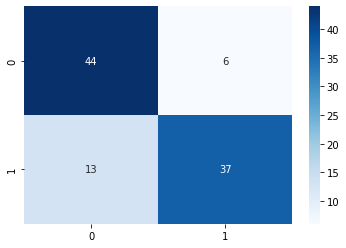

In [58]:
import numpy as np

y_pred = []
y_true = []
for images, labels in test_data:
    label = np.array(labels)
    pred = model3.predict(images)
    for i in pred:
      y_pred.append(round(i[0]))
    for i in label: 
      y_true.append(int(i))

plot_confusion_matrix(y_true, y_pred)